In [1]:
!pip install pycaret
print("Pycaret installed sucessfully!!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.6 

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [3]:
data = pd.read_csv('/kaggle/input/co-and-nox-data/gt_2015.csv')
data.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  1.95320  1020.1  84.985  2.5304  20.116  1048.7  544.92  116.27  10.799   
1  1.21910  1020.1  87.523  2.3937  18.584  1045.5  548.50  109.18  10.347   
2  0.94915  1022.2  78.335  2.7789  22.264  1068.8  549.95  125.88  11.256   
3  1.00750  1021.7  76.942  2.8170  23.358  1075.2  549.63  132.21  11.702   
4  1.28580  1021.6  76.732  2.8377  23.483  1076.2  549.68  133.58  11.737   

       CO      NOX  
0  7.4491  113.250  
1  6.4684  112.020  
2  3.6335   88.147  
3  3.1972   87.078  
4  2.3833   82.515

In [4]:
subcluster_sizes = [3, 4, 5]

In [5]:
# Define clustering algorithms
clustering_algorithms = {
    'KMeans': KMeans,
    'AgglomerativeClustering': AgglomerativeClustering,
    'DBSCAN': DBSCAN
}

In [6]:
# Initialize dictionaries to store results for each algorithm
results_dict = {algorithm_name: [] for algorithm_name in clustering_algorithms.keys()}

In [7]:
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.")

In [8]:
# Loop through different clustering algorithms
for algorithm_name, algorithm in clustering_algorithms.items():
    # Loop through different data processing methods
    for processing_method in ['No Data Processing', 'Normalization', 'Transformation', 'PCA', 'T+N', 'T+N+PCA']:
        for subcluster_size in subcluster_sizes:
            # Apply data processing based on the method
            processed_data = data.copy()  # Assume no processing by default
            if processing_method == 'Normalization':
                scaler = MinMaxScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'Transformation':
                scaler = StandardScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'PCA':
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(data)
            elif processing_method == 'T+N':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                processed_data = transformed_data
            elif processing_method == 'T+N+PCA':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(transformed_data)
            
            # Perform clustering
            if algorithm_name == 'DBSCAN':
                clusters = algorithm(eps=0.5, min_samples=5).fit_predict(processed_data)
            else:
                clusters = algorithm(n_clusters=subcluster_size).fit_predict(processed_data)
            
            # Check if clustering generated valid clusters
            unique_labels = len(set(clusters))
            if unique_labels > 1:
                # Calculate evaluation metrics
                silhouette = silhouette_score(processed_data, clusters)
                calinski_harabasz = calinski_harabasz_score(processed_data, clusters)
                davies_bouldin = davies_bouldin_score(processed_data, clusters)
                
                # Append results to the list
                results_dict[algorithm_name].append({
                    'Algorithm': algorithm_name,
                    'Processing Method': processing_method,
                    'Subcluster Size': subcluster_size,
                    'Silhouette Score': silhouette,
                    'Calinski-Harabasz Score': calinski_harabasz,
                    'Davies-Bouldin Score': davies_bouldin
                })

In [9]:
# Create DataFrames for each algorithm
dfs = {}
for algorithm_name, results in results_dict.items():
    dfs[algorithm_name] = pd.DataFrame(results)

# Print the results in a beautiful table format
for algorithm_name, df in dfs.items():
    print(f"Clustering Algorithm: {algorithm_name}\n")
    print(df.to_string(index=False))
    print("\n\n")

Clustering Algorithm: KMeans

Algorithm  Processing Method  Subcluster Size  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
   KMeans No Data Processing                3          0.384585              2393.003014              0.954584
   KMeans No Data Processing                4          0.334765              2183.657053              1.066615
   KMeans No Data Processing                5          0.328534              2103.367574              1.117133
   KMeans      Normalization                3          0.380850              2379.455299              0.992413
   KMeans      Normalization                4          0.331213              2247.854376              1.062570
   KMeans      Normalization                5          0.328583              2072.797741              1.107599
   KMeans     Transformation                3          0.319812              1719.292632              1.148595
   KMeans     Transformation                4          0.288845              1580.

In [10]:
# Save results as CSV files
for algorithm_name, df in dfs.items():
    filename = f"{algorithm_name}_results.csv"
    df.T.to_csv(filename)
    print(f"{filename} saved successfully.\n")

KMeans_results.csv saved successfully.

AgglomerativeClustering_results.csv saved successfully.

DBSCAN_results.csv saved successfully.



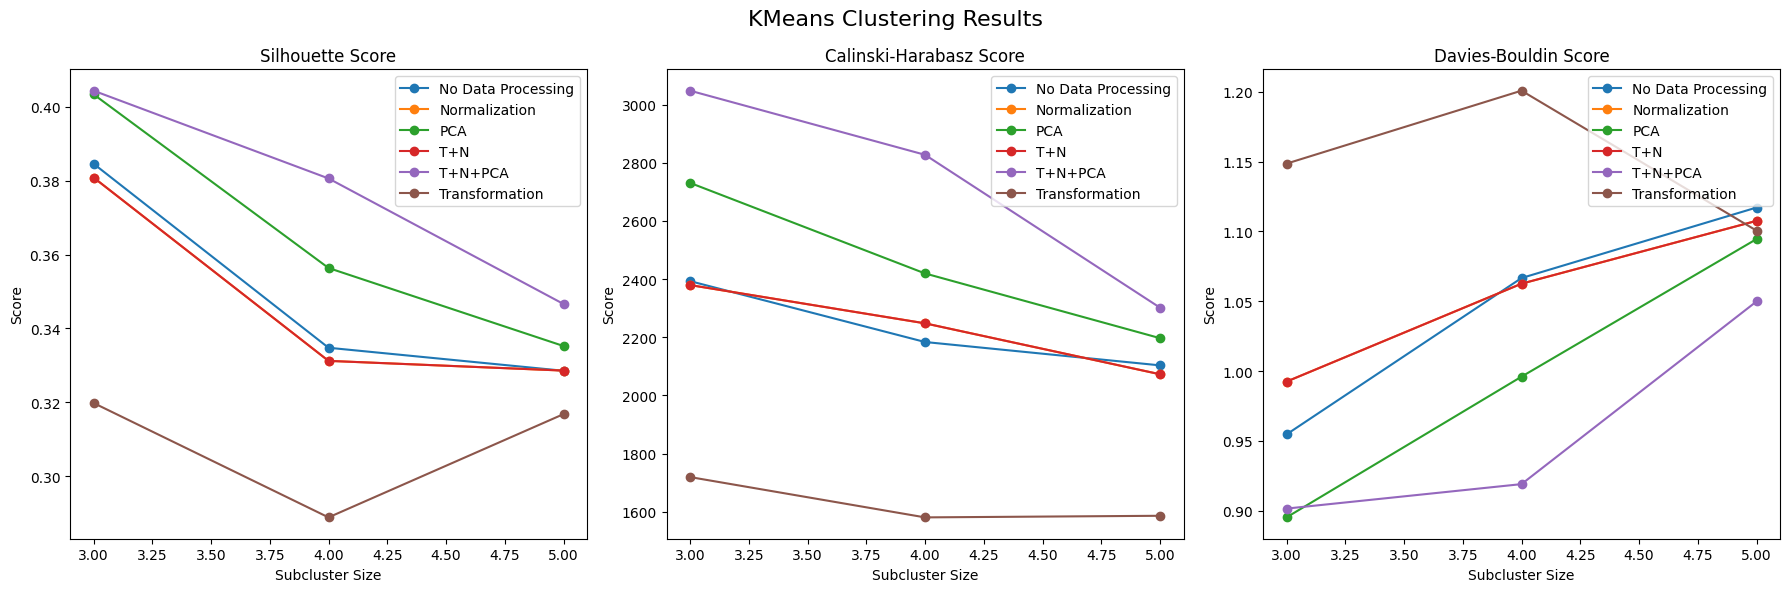

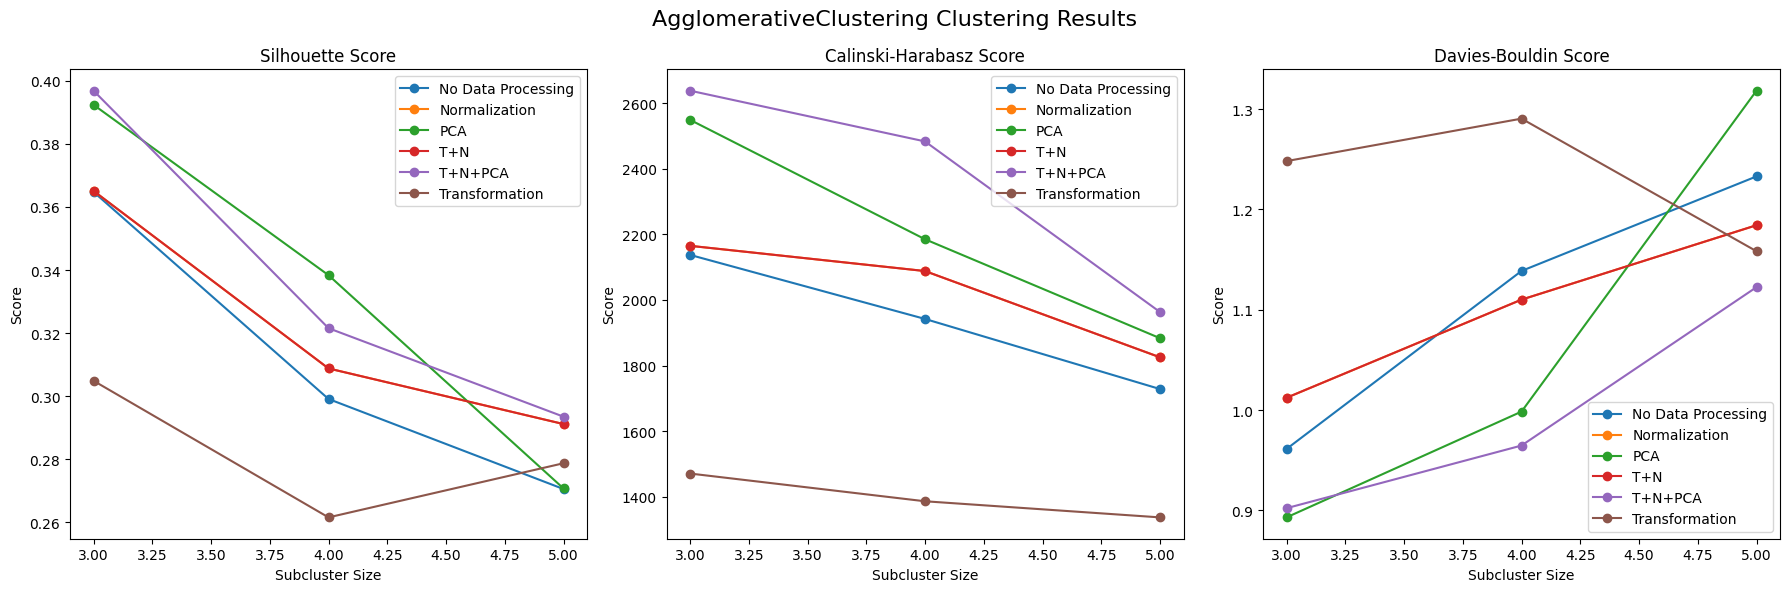

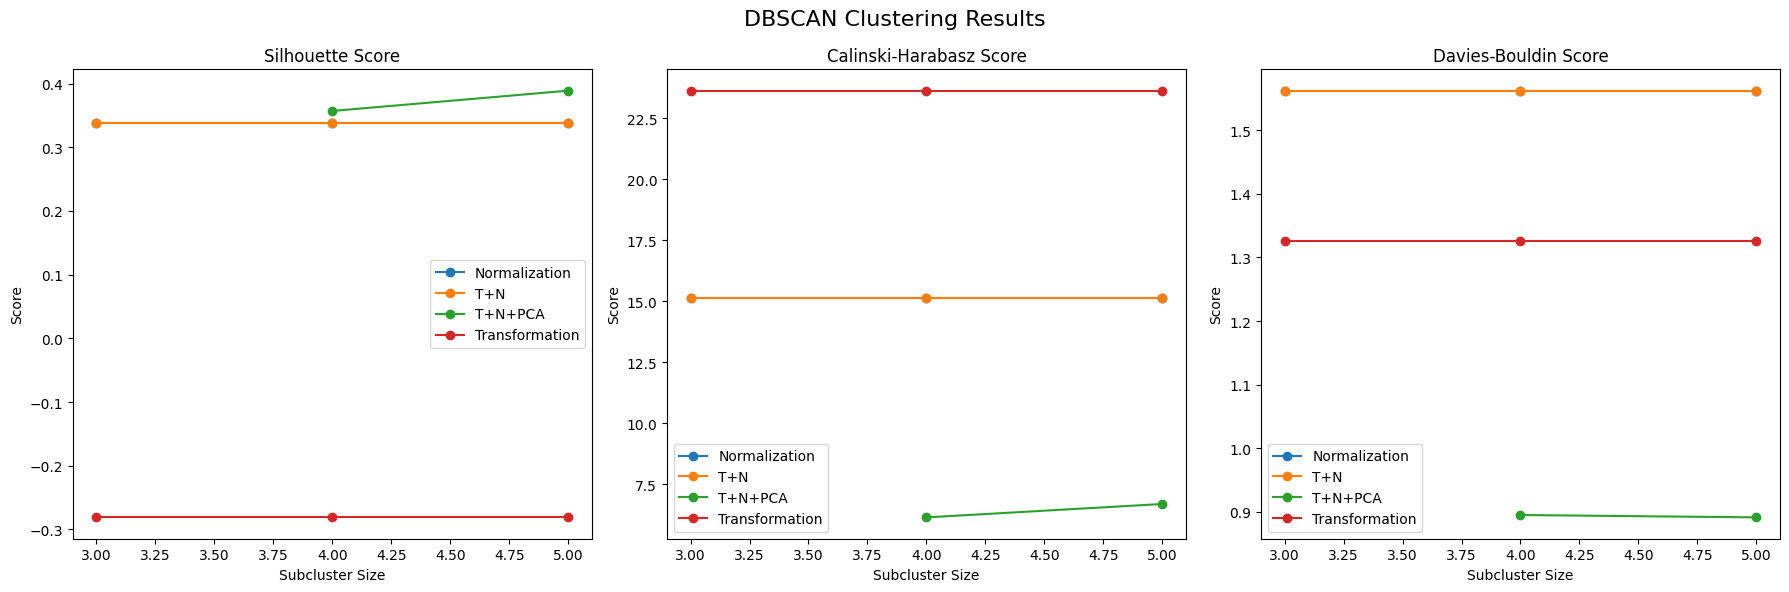

In [11]:
# Define function to plot graphs for each clustering algorithm
import matplotlib.pyplot as plt

def plot_results_per_algorithm(algorithm_name, df):
    # Create subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot each metric
    for i, metric in enumerate(['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']):
        ax = axs[i]
        for method, method_df in df.groupby('Processing Method'):
            ax.plot(method_df['Subcluster Size'], method_df[metric], marker='o', label=method)
        ax.set_title(metric)
        ax.set_xlabel('Subcluster Size')
        ax.set_ylabel('Score')
        ax.legend()

    # Set title for the entire plot
    plt.suptitle(f'{algorithm_name} Clustering Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot results for each algorithm
for algorithm_name, df in dfs.items():
    plot_results_per_algorithm(algorithm_name, df)

# KMeans Clustering

## No Data Processing

In [12]:
from pycaret.clustering import *
kMeanClusteringParameters = setup(data, verbose=False)
KMeanClusteringModel = create_model('kmeans', num_clusters=4)
kMeanPrediction = assign_model(KMeanClusteringModel)
kMeanPrediction

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

AT           AP         AH    AFDP       GTEP          TIT  \
0      1.953200  1020.099976  84.985001  2.5304  20.115999  1048.699951   
1      1.219100  1020.099976  87.523003  2.3937  18.584000  1045.500000   
2      0.949150  1022.200012  78.334999  2.7789  22.264000  1068.800049   
3      1.007500  1021.700012  76.942001  2.8170  23.358000  1075.199951   
4      1.285800  1021.599976  76.732002  2.8377  23.483000  1076.199951   
...         ...          ...        ...     ...        ...          ...   
2994  27.535999  1010.799988  50.452000  3.7943  26.346001  1088.699951   
2995  27.982000  1010.599976  48.841000  3.7712  26.285000  1087.900024   
2996  27.836000  1010.500000  49.382000  3.7353  26.091000  1087.099976   
2997  26.320999  1010.099976  53.993000  3.6835  26.148001  1086.699951   
2998  26.052999  1009.500000  54.701000  3.6886  26.424000  1088.000000   

             TAT         TEY     CDP      CO         NOX    Cluster  
0     544.919983  116.269997  10.799  7.4491  113.250000  Cluster 1  
1     548.500000  109.180000  10.347  6.4684  112.019997  Cluster 1  
2     549.950012  125.879997  11.256  3.6335   88.147003  Cluster 2  
3     549.630005  132.210007  11.702  3.1972   87.078003  Cluster 2  
4     549.679993  133.580002  11.737  2.3833   82.514999  Cluster 2  
...          ...         ...     ...     ...         ...        ...  
2994  550.059998  136.429993  12.346  1.4288   55.308998  Cluster 0  
2995  550.039978  135.740005  12.256  1.6313   54.307999  Cluster 0  
2996  550.030029  135.410004  12.211  1.6754   55.298000  Cluster 0  
2997  550.020020  135.520004  12.266  1.6924   55.221001  Cluster 0  
2998  550.010010  136.029999  12.375  1.5379   56.344002  Cluster 0  

[2999 rows x 12 columns]

In [13]:
x = save_model(KMeanClusteringModel, 'kMeanClusteringModelFile')

Transformation Pipeline and Model Successfully Saved


In [14]:
KMeanClusteringModel1 = load_model('kMeanClusteringModelFile')

Transformation Pipeline and Model Successfully Loaded


In [15]:
evaluate_model(KMeanClusteringModel)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [16]:
plot_model(KMeanClusteringModel, plot='cluster')

In [17]:
plot_model(KMeanClusteringModel, plot = 'tsne')

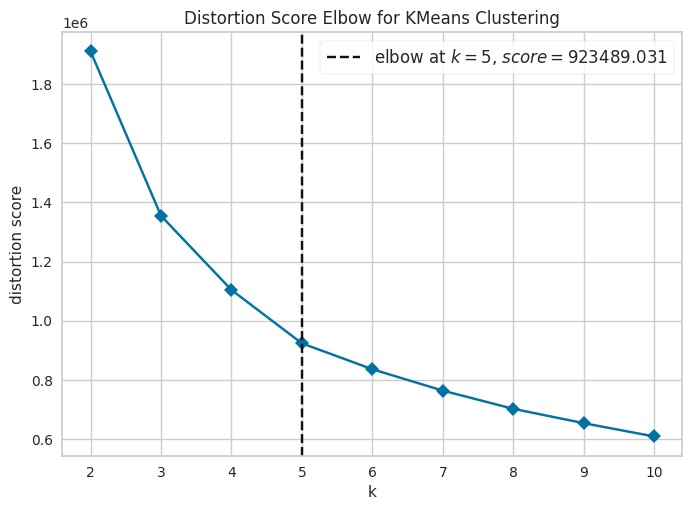

In [18]:
plot_model(KMeanClusteringModel, plot = 'elbow')

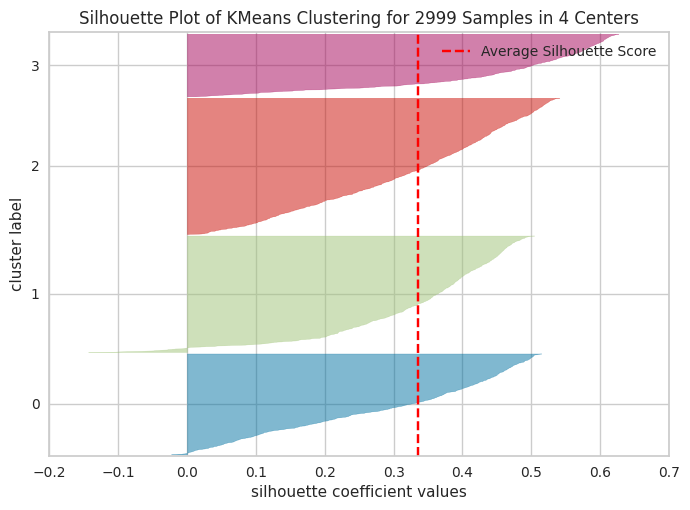

In [19]:
plot_model(KMeanClusteringModel, plot = 'silhouette')

In [20]:
plot_model(KMeanClusteringModel, plot = 'distribution')

## Normalization

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

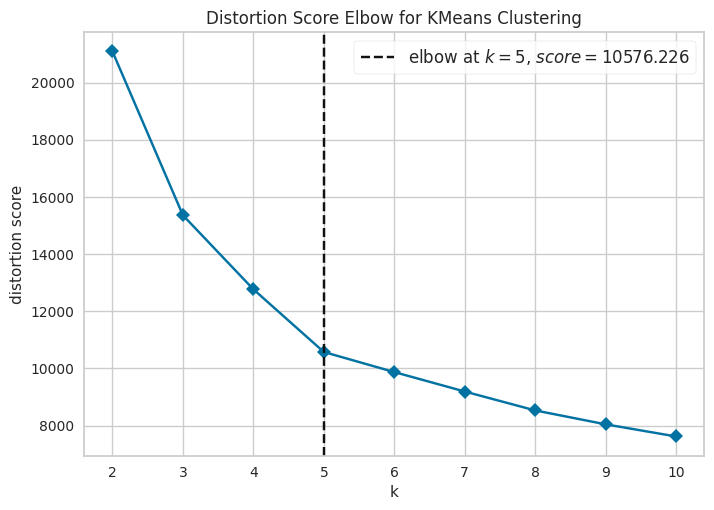

In [21]:
setup(data = data, normalize = True, normalize_method = 'zscore', verbose=False)
x = create_model('kmeans')
plot_model(x, plot = 'elbow')

In [22]:
setup(data = data, normalize = True, normalize_method = 'zscore', verbose=False)

print("For Cluster = 3")
x = create_model('kmeans', num_clusters = 3)

print("For Cluster = 4")
x = create_model('kmeans', num_clusters = 4)

print("For Cluster = 5")
x = create_model('kmeans', num_clusters = 5)

print("For Cluster = 6")
x = create_model('kmeans', num_clusters = 6)

For Cluster = 3


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 4


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 5


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 6


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
setup(data = data, normalize = True, normalize_method = 'zscore', verbose=False)
x = create_model('kmeans', num_clusters = 5)
plot_model(x, plot = 'cluster')
plot_model(x, plot = 'tsne')
plot_model(x, plot = 'distribution')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Transformation

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

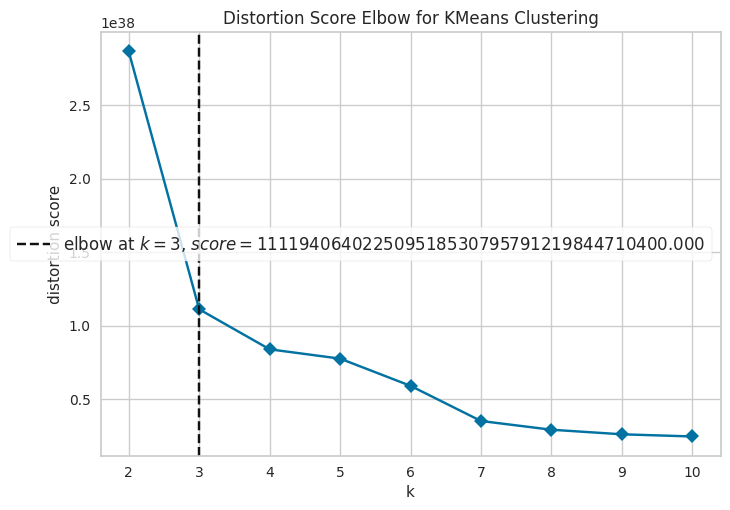

In [24]:
setup(data = data, transformation = True, transformation_method = 'yeo-johnson', verbose=False)
x = create_model('kmeans')
plot_model(x, plot = 'elbow')

In [25]:
setup(data = data, transformation = True, transformation_method = 'yeo-johnson', verbose=False)

print("For Cluster = 3")
x = create_model('kmeans', num_clusters = 3)

print("For Cluster = 4")
x = create_model('kmeans', num_clusters = 4)

print("For Cluster = 5")
x = create_model('kmeans', num_clusters = 5)

print("For Cluster = 6")
x = create_model('kmeans', num_clusters = 6)

For Cluster = 3


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 4


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 5


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 6


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
setup(data = data, transformation = True, transformation_method = 'yeo-johnson', verbose=False)
x = create_model('kmeans', num_clusters = 3)
plot_model(x, plot = 'cluster')
plot_model(x, plot = 'tsne')
plot_model(x, plot = 'distribution')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Using PCA

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

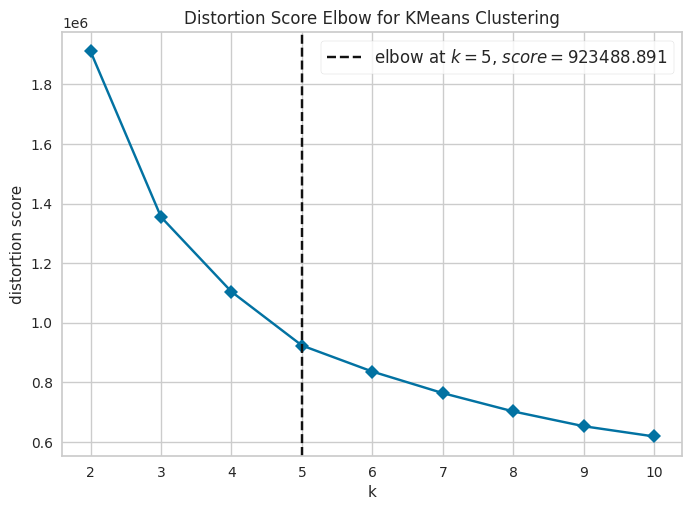

In [27]:
setup(data = data, pca = True, pca_method = 'linear', verbose=False)
x = create_model('kmeans')
plot_model(x, plot = 'elbow')

In [28]:
setup(data = data, pca = True, pca_method = 'linear', verbose=False)

print("For Cluster = 3")
x = create_model('kmeans', num_clusters = 3)

print("For Cluster = 4")
x = create_model('kmeans', num_clusters = 4)

print("For Cluster = 5")
x = create_model('kmeans', num_clusters = 5)

print("For Cluster = 6")
x = create_model('kmeans', num_clusters = 6)

For Cluster = 3


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 4


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 5


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 6


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
setup(data = data, pca = True, pca_method = 'linear', verbose=False)
x = create_model('kmeans', num_clusters = 5)
plot_model(x, plot = 'cluster')
plot_model(x, plot = 'tsne')
plot_model(x, plot = 'distribution')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Model Performance using "Transformation" + "Normalization

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

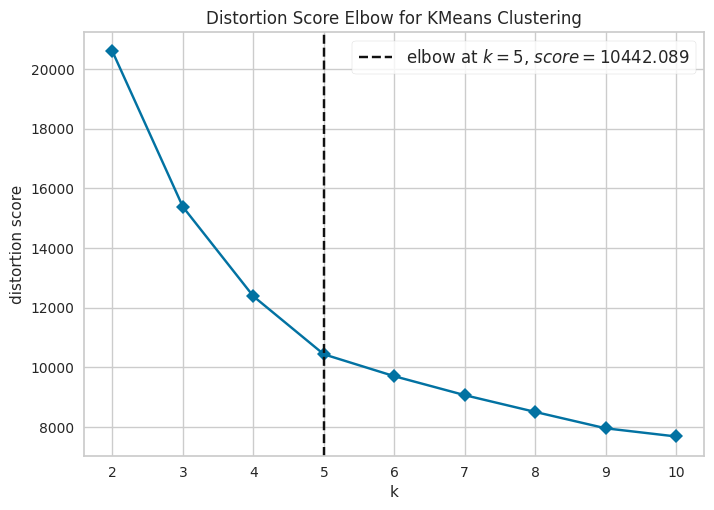

In [30]:
setup(data = data, transformation = True, normalize = True,
      normalize_method = 'zscore', transformation_method = 'yeo-johnson', verbose=False)
x = create_model('kmeans')
plot_model(x, plot = 'elbow')

In [31]:
setup(data = data, transformation = True, normalize = True,
      normalize_method = 'zscore', transformation_method = 'yeo-johnson', verbose=False)

print("For Cluster = 3")
x = create_model('kmeans', num_clusters = 3)

print("For Cluster = 4")
x = create_model('kmeans', num_clusters = 4)

print("For Cluster = 5")
x = create_model('kmeans', num_clusters = 5)

print("For Cluster = 6")
x = create_model('kmeans', num_clusters = 6)

For Cluster = 3


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 4


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 5


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 6


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
setup(data = data, transformation = True, normalize = True,
      normalize_method = 'zscore', transformation_method = 'yeo-johnson', verbose=False)
x = create_model('kmeans', num_clusters = 5)
plot_model(x, plot = 'cluster')
plot_model(x, plot = 'tsne')
plot_model(x, plot = 'distribution')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Model Performance using "Transformation" + "Normalization" + "PCA"

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

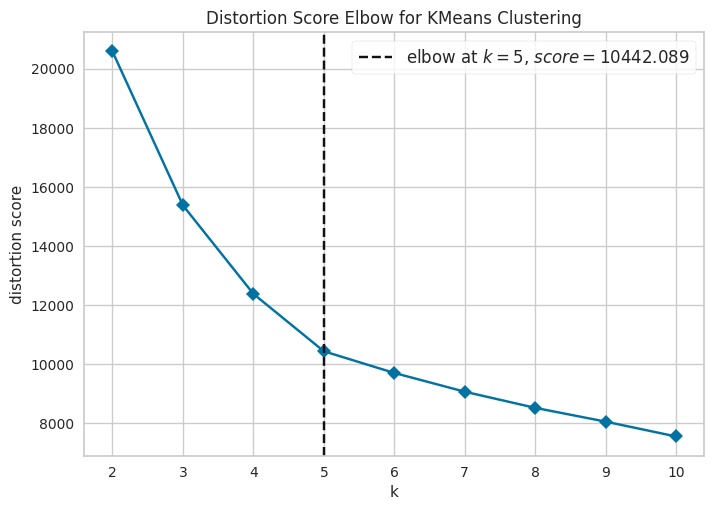

In [33]:
setup(data = data, transformation = True, normalize = True, pca = True,
      normalize_method = 'zscore', transformation_method = 'yeo-johnson',
      pca_method = 'linear', verbose=False)
x = create_model('kmeans')
plot_model(x, plot = 'elbow')

In [34]:
setup(data = data, transformation = True, normalize = True, pca = True,
      normalize_method = 'zscore',
      transformation_method = 'yeo-johnson',
      pca_method = 'linear', verbose=False)

print("For Cluster = 3")
x = create_model('kmeans', num_clusters = 3)

print("For Cluster = 4")
x = create_model('kmeans', num_clusters = 4)

print("For Cluster = 5")
x = create_model('kmeans', num_clusters = 5)

print("For Cluster = 6")
x = create_model('kmeans', num_clusters = 6)

For Cluster = 3


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 4


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 5


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

For Cluster = 6


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
setup(data = data, transformation = True, normalize = True, pca = True,
      normalize_method = 'zscore',
      transformation_method = 'yeo-johnson',
      pca_method = 'linear', verbose=False)
x = create_model('kmeans', num_clusters = 5)
plot_model(x, plot = 'cluster')
plot_model(x, plot = 'tsne')
plot_model(x, plot = 'distribution')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# AgglomerativeClustering

## No Data Processing

In [36]:
from pycaret.clustering import *
AgglomerativeClusteringParameters = setup(data, verbose=False)
AgglomerativeClusteringModel = create_model('hclust', num_clusters=4)
AgglomerativeClusteringPrediction = assign_model(AgglomerativeClusteringModel)
AgglomerativeClusteringPrediction

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

AT           AP         AH    AFDP       GTEP          TIT  \
0      1.953200  1020.099976  84.985001  2.5304  20.115999  1048.699951   
1      1.219100  1020.099976  87.523003  2.3937  18.584000  1045.500000   
2      0.949150  1022.200012  78.334999  2.7789  22.264000  1068.800049   
3      1.007500  1021.700012  76.942001  2.8170  23.358000  1075.199951   
4      1.285800  1021.599976  76.732002  2.8377  23.483000  1076.199951   
...         ...          ...        ...     ...        ...          ...   
2994  27.535999  1010.799988  50.452000  3.7943  26.346001  1088.699951   
2995  27.982000  1010.599976  48.841000  3.7712  26.285000  1087.900024   
2996  27.836000  1010.500000  49.382000  3.7353  26.091000  1087.099976   
2997  26.320999  1010.099976  53.993000  3.6835  26.148001  1086.699951   
2998  26.052999  1009.500000  54.701000  3.6886  26.424000  1088.000000   

             TAT         TEY     CDP      CO         NOX    Cluster  
0     544.919983  116.269997  10.799  7.4491  113.250000  Cluster 0  
1     548.500000  109.180000  10.347  6.4684  112.019997  Cluster 0  
2     549.950012  125.879997  11.256  3.6335   88.147003  Cluster 1  
3     549.630005  132.210007  11.702  3.1972   87.078003  Cluster 1  
4     549.679993  133.580002  11.737  2.3833   82.514999  Cluster 1  
...          ...         ...     ...     ...         ...        ...  
2994  550.059998  136.429993  12.346  1.4288   55.308998  Cluster 3  
2995  550.039978  135.740005  12.256  1.6313   54.307999  Cluster 3  
2996  550.030029  135.410004  12.211  1.6754   55.298000  Cluster 3  
2997  550.020020  135.520004  12.266  1.6924   55.221001  Cluster 3  
2998  550.010010  136.029999  12.375  1.5379   56.344002  Cluster 3  

[2999 rows x 12 columns]

In [37]:
x = save_model(AgglomerativeClusteringModel, 'AgglomerativeClusteringModelFile')

Transformation Pipeline and Model Successfully Saved


In [38]:
AgglomerativeClusteringModel1 = load_model('AgglomerativeClusteringModelFile')

Transformation Pipeline and Model Successfully Loaded


In [39]:
evaluate_model(AgglomerativeClusteringModel)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

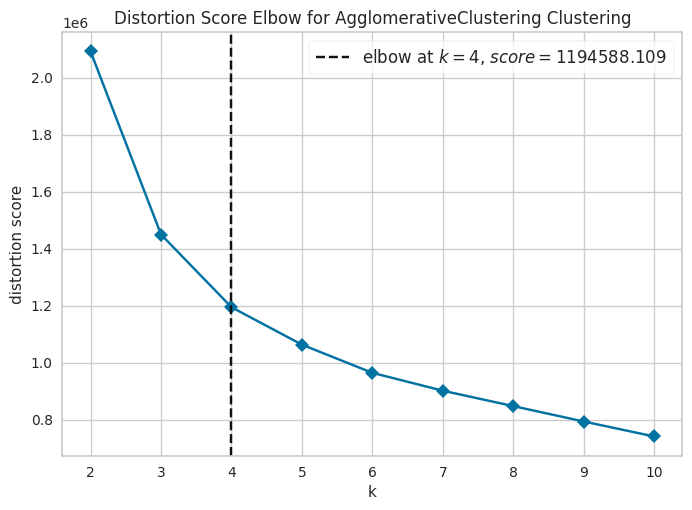

In [40]:
plot_model(AgglomerativeClusteringModel, plot = 'elbow')
plot_model(AgglomerativeClusteringModel, plot = 'cluster')
plot_model(AgglomerativeClusteringModel, plot = 'tsne')
#plot_model(AgglomerativeClusteringModel, plot = 'silhouette')
plot_model(AgglomerativeClusteringModel, plot = 'distribution')

## Using Normalization

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

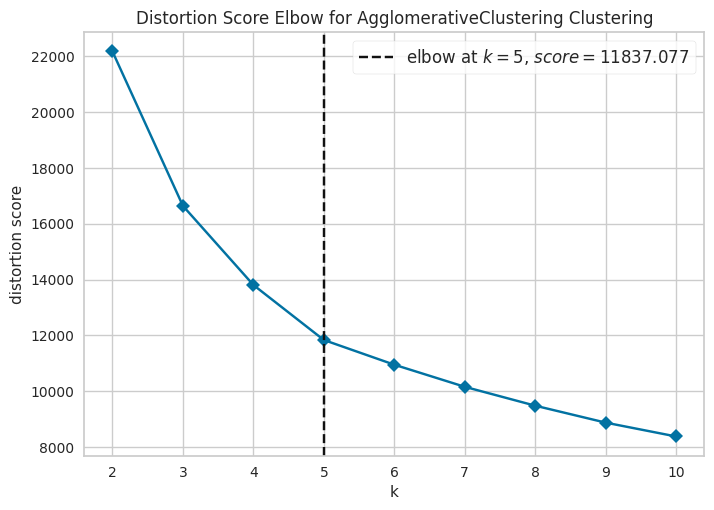

In [41]:
setup(data = data, normalize = True, normalize_method = 'zscore', verbose=False)
x = create_model('hclust')
plot_model(x, plot = 'elbow')